## Imports

In [1]:
#!/usr/bin/env python3
 # -*- coding: utf-8 -*-

from __future__ import print_function
from __future__ import division

# Standard Library, plus some Third Party Libraries
from pprint import pprint
from PIL import Image
from tqdm import tqdm
from typing import Union, Tuple

from pathlib import Path
from collections import namedtuple
from operator import methodcaller
from io import BytesIO

from functools import partial
import collections
import operator

import copy
import datetime
import h5py
import math
import os
import random
import shutil
import sys
import re
import time
# import visdom

# Data Science and Machine Learning Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, CenterCrop, Normalize

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# skimage
import skimage
import skimage.metrics as skmetrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

## Functions

In [2]:
def get_cropped_by_center_image(im, target = 25):
    width, height = im.size

    def get_new_targets(target, size):
        offset = target // 2
        if target % 2 == 0:
            extreme_1 = size // 2
            residual = 0
        else:
            extreme_1 = size // 2 - 1
            residual = 1
            pass
        extreme_2 = size // 2
        return extreme_1 - offset + residual, extreme_2 + offset + residual

    left, right = get_new_targets(target, width)
    top, bottom = get_new_targets(target, height)

    # print(im.crop((left, top, right, bottom)).size)
    # print((left, top, right, bottom))

    im_cropped = im.crop((left, top, right, bottom))
    return im_cropped

def get_transformer(flag_crop_img, im, sidelength):
    if flag_crop_img:
        sidelength = min(im.size)
        my_transform = transforms.Compose(
            [
                transforms.CenterCrop(sidelength),
                transforms.ToTensor(),
                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                transforms.Normalize([0.5], [0.5])])
    else:
        sidelength = None
        my_transform = transforms.Compose(
            [
            # transforms.CenterCrop(sidelength),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            transforms.Normalize([0.5], [0.5])])
        pass
    return my_transform

def get_rescaled_data(data):
    scaler = MinMaxScaler((0, 255))
    # print(scaler.fit(data.reshape(-1, 1)))
    # print(scaler.data_max_)

    # print(scaler.transform(data.reshape(-1, 1)))
    return scaler.fit_transform(data.reshape(-1, 1))

def compute_scaling(im, flag_crop_img = False, sidelength = None, show_scores = False, show_fig = False):

    # Get transformations to be applied.
    my_transform = get_transformer(flag_crop_img, im, sidelength)

    # Transform input image.
    data_tensor = my_transform(im)
    sidelength_tensor = data_tensor.size()[1] * data_tensor.size()[2]
    data = data_tensor.view(sidelength_tensor).numpy()

    # Rescale data back to [0-255] interval
    data_rescaled = get_rescaled_data(data)
    res_arr = np.around(data_rescaled).astype(np.uint8).flatten()

    # Show metrices: using directly scaled back data.
    if show_scores:
        score_psnr = psnr(np.asarray(im, dtype=np.uint8).flatten(), res_arr, data_range = 255)
        print('Score PSNR', score_psnr, 'db')

    im_res = Image.fromarray(res_arr.reshape(im.size[1], im.size[0]))
    
    # Show metrices: using directly scaled back data converted firstly
    # also back into PIL Image.
    if show_scores:
        score_psnr = psnr(np.asarray(im, dtype=np.uint8).flatten(), np.asarray(im_res, dtype=np.uint8).flatten(), data_range = 255)
        print('Score PSNR', score_psnr, 'db')

    # Show images: Ground Thruth (Cropped image)
    # and Reconstructed image.
    if show_fig:
        fig, axes = plt.subplots(1, 2, figsize = (10, 5))

        axes[0].imshow(im)
        axes[0].set_title('Cropped')

        axes[1].imshow(im_res)
        axes[1].set_title('Reconstructed')

        plt.show()
        pass

    # Compute scores to be retrieved.
    score_mse = mean_squared_error(np.asarray(im, dtype=np.uint8).flatten(), np.asarray(im_res, dtype=np.uint8).flatten())
    score_psnr = psnr(np.asarray(im, dtype=np.uint8).flatten(), np.asarray(im_res, dtype=np.uint8).flatten(), data_range = 255)
    score_ssim = ssim(np.asarray(im, dtype=np.uint8).flatten(), np.asarray(im_res, dtype=np.uint8).flatten(), data_range = 255)
    return score_mse, score_psnr, score_ssim

## Code

### First Attempt

In [3]:
flag_crop_img = False

(481, 321)


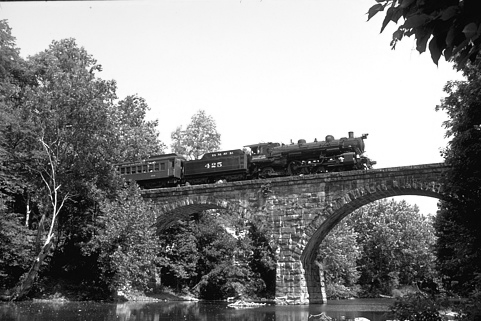

In [4]:
im = Image.open('/content/test068.png')
print(im.size)
im

In [5]:
width, height = im.size

target = 25

def get_new_targets(target, size):
    offset = target // 2
    if target % 2 == 0:
        extreme_1 = size // 2
        residual = 0
    else:
        extreme_1 = size // 2 - 1
        residual = 1
        pass
    extreme_2 = size // 2
    return extreme_1 - offset + residual, extreme_2 + offset + residual

left, right = get_new_targets(target, width)
top, bottom = get_new_targets(target, height)

print(im.crop((left, top, right, bottom)).size)
print((left, top, right, bottom))

im_cropped = im.crop((left, top, right, bottom))
im_cropped

(25, 25)
(228, 148, 253, 173)


In [6]:
compute_scaling(im = im.crop((left, top, right, bottom)), flag_crop_img = True, sidelength = target)

(56.7136, 30.59393145066446, 0.9694869787169308)

In [7]:
compute_scaling(im = im, flag_crop_img = False, sidelength = None)

(0.5726776380981988, 50.551701357433444, 0.999638952188769)

### Dataframe based Attempt

In [8]:
# 'namedtuple'-like python objet used to collect data in proper way.
typename = 'DataRecord'
fields_name = 'crop_size;mse;psnr;ssim;bpp;file_size_bits'.split(";")
DataRecord = collections.namedtuple(typename, fields_name)

In [9]:
results_score_psnr = [] # List that will contain all records.
crop_sizes = np.arange(100, min(im.size)+1) # Sizes for center cropping image.
cropped_file_size_bits = None  # tmp variable used within cycle.

for size in crop_sizes:
    # --- Crop original image from its center.
    im_cropped = get_cropped_by_center_image(im, target = size)

    # score_mse, score_psnr, score_ssim = compute_scaling(im = im_cropped, flag_crop_img = True, sidelength = size, show_scores = False, show_fig = False)
    # results_score_psnr.append(DataRecord._make([crop_sizes, score_mse, score_psnr, score_ssim]))

    # --- Get cropped file size in bits,
    # that is, multiplying by 8 times the
    # value retrived as byte from mapped area in memory.
    with BytesIO() as f:
        im_cropped.save(f, format='PNG')
        cropped_file_size_bits = f.getbuffer().nbytes * 8
        pass
    
    # --- Compute quantities to be 
    # included for creating a new record of data.
    pixels = size ** 2
    bpp = cropped_file_size_bits / pixels
    score_mse, score_psnr, score_ssim = compute_scaling(
        im = im_cropped,
        flag_crop_img = True,
        sidelength = size,
        show_scores = False,
        show_fig = False)

    # --- Create new data record
    values = [size, score_mse, score_psnr, score_ssim, bpp, cropped_file_size_bits]
    a_record = DataRecord._make(values)

    # --- Append data record, once created.
    results_score_psnr.append(a_record)
    pass

In [10]:
# Create dataframe for in-depth analyses.
data = list(map(operator.methodcaller("_asdict"), results_score_psnr))
data_df = pd.DataFrame(data = data)

data_df.head(5)

,crop_size,mse,psnr,ssim,bpp,file_size_bits
0,100,3.253500,43.007295,0.997856,5.328000,53280
1,101,3.251838,43.009515,0.997892,5.345358,54528
2,102,3.222895,43.048342,0.997910,5.314879,55296
3,103,3.230088,43.038661,0.997939,5.328306,56528
4,104,3.196930,43.083472,0.997958,5.302515,57352


In [11]:
data_df.sort_values(by = ['psnr'], ascending=False).head(5)

,crop_size,mse,psnr,ssim,bpp,file_size_bits
192,292,0.481200,51.307551,0.999819,4.919966,419496
194,294,0.481235,51.307235,0.999818,4.920635,425320
190,290,0.481308,51.306573,0.999820,4.921189,413872
196,296,0.481408,51.305675,0.999817,4.915997,430720
188,288,0.481433,51.305443,0.999820,4.925829,408568


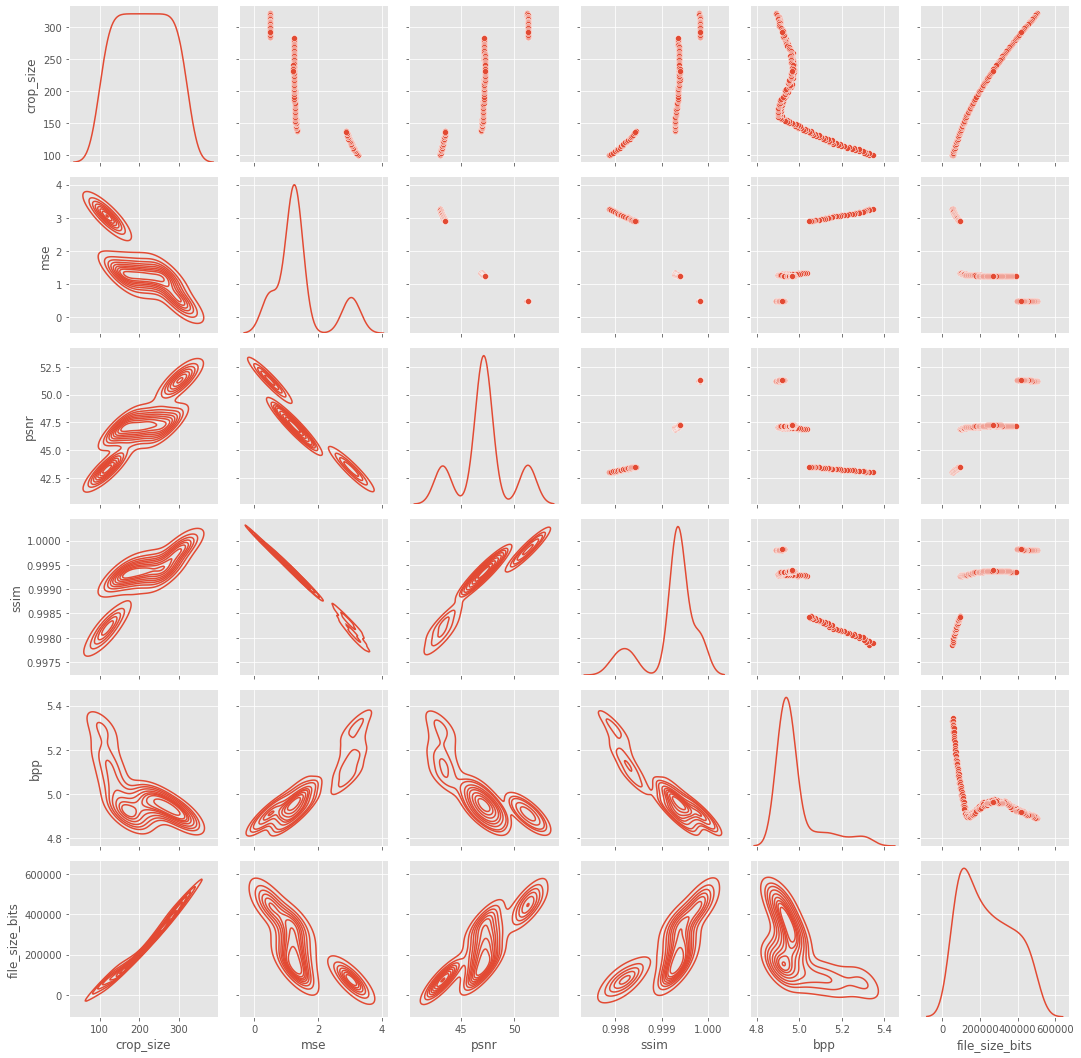

In [16]:
# Get the big picture.
data_df_sorted = data_df.sort_values(by = ['psnr'])

g = sns.PairGrid(data_df_sorted, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
_ = g.map_diag(sns.kdeplot)

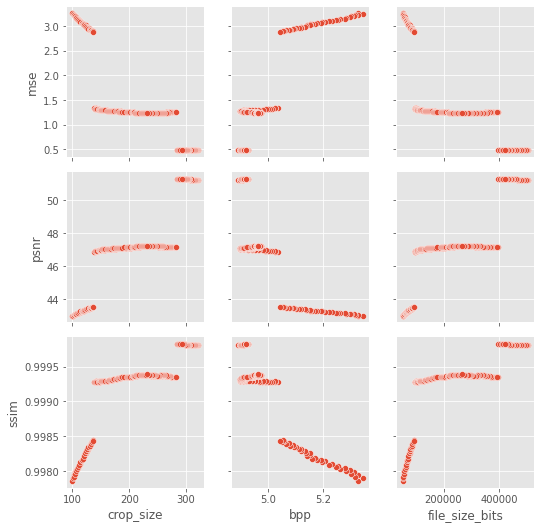

In [17]:
# Narrow down view to less pairs of attributes.
data_df_sorted = data_df.sort_values(by = ['psnr'])

x_vars=['crop_size', 'bpp', 'file_size_bits']
y_vars=['mse', 'psnr', 'ssim']
g = sns.PairGrid(data_df_sorted, x_vars=x_vars, y_vars=y_vars)

_ = g.map(sns.scatterplot)
# g.map(sns.histplot)
# g.map(sns.kdeplot)

# Example of usage of 'operator.attrgetter':
# y = np.array(list(map(operator.attrgetter('mse'), results_score_psnr)))
# plt.scatter(x = crop_sizes, y = y)
# plt.show()

## References

- **skimage references:**
  - [Module: metrics](https://scikit-image.org/docs/dev/api/skimage.metrics.html#module-skimage.metrics)

- **Seaborn references:**
  - [seaborn.PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html)

- **sklearn references:**
  - [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

- **Pytorch references:**
  - [TORCHVISION.TRANSFORMS](https://pytorch.org/docs/stable/torchvision/transforms.html)
  - ["PyTorch - Data loading, preprocess, display and torchvision."](https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/)


- Generic References:
  - [FORM](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=3jKM6GfzlgpS)
